In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data

In [3]:
datas = pd.read_csv("datas/movielens_small/ratings.csv")

datas.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# 2. Data Analysis

In [4]:
# 1. describe (통계 정보 1. value)
datas.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [5]:
# 2. info (통계 정보 2. data structure)
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
# 3. 불필요한 칼럼 제거
datas.drop("timestamp", axis=1, inplace=True)
datas.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
# 4. unique data set check
print("사용자 수 : {} 명".format(datas['userId'].unique().size))
print("평가된 영화 수 : {} 개".format(datas['movieId'].unique().size))

사용자 수 : 671 명
평가된 영화 수 : 9066 개


# 2. Matrix Factorization

## 1. MF Model Process

In [8]:
# 1. split train and test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(datas, test_size=0.2, random_state=42)
print("Train dataset shape : {}".format(train_df.shape))
print("Test dataset shape : {}".format(test_df.shape))

Train dataset shape : (80003, 3)
Test dataset shape : (20001, 3)


In [9]:
# 2. set pivot
pivot_df = train_df.pivot_table("rating", index="userId", columns="movieId")
pivot_df.fillna(0, inplace=True)
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 3. Setting Value
Interaction = pivot_df.to_numpy()

num_user, num_item = Interaction.shape
latent_factor = 20
learning_rate = 0.01
reg = 0.01

In [11]:
# 4. Setting Latent Factor Matrix p_u(사용자), q_i(아이템)
p_u = np.random.normal(size=(num_user, latent_factor))
q_i = np.random.normal(size=(num_item, latent_factor))

print("사용자 수 : {} 명, 사용자 잠재 변수 행렬 shape {}".format(num_user, p_u.shape))
print("영화 수 : {} 개, 영화 잠재 변수 행렬 shape {}".format(num_item, q_i.shape))

사용자 수 : 671 명, 사용자 잠재 변수 행렬 shape (671, 20)
영화 수 : 8399 개, 영화 잠재 변수 행렬 shape (8399, 20)


#### 사용자, 아이템 별로 랜덤한 잠재 변수 행렬이 각 각의 요소의 크기만큼, latent_factor 사이즈 만큼 만들어진 것을 알 수 있음

In [12]:
# 5. Confidence ref.Inputs with varying confidence levels
user_confidence = (pivot_df > 0).sum(axis=1)
item_confidence = (pivot_df > 0).sum(axis=0)

## 사용자의 평점 빈도 수(크기가 될 수 있음) 및 해당 사용자가 평가한 영화의 평점 발생 빈도 수(크기가 될 수 있음)을 더해
### 평가에 대한 신뢰도 부여
confidences = train_df.apply(lambda x: 
                   user_confidence.loc[x['userId']] + 
                   item_confidence.loc[x['movieId']], axis=1)
train_df['confidence'] = confidences
train_df.head()

,userId,movieId,rating,confidence
37865,273,5816,4.5,138
46342,339,2028,4.5,229
64614,461,3895,0.5,555
41974,300,3578,4.5,170
50236,369,292,3.0,139


In [13]:
# 6. Set confidence pivot
confidence_df = train_df.pivot_table(values="confidence", index="userId", columns="movieId")
confidence_df.fillna(1, inplace=True)

confidence_matrix = confidence_df.to_numpy()

confidence_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,163.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
# 7. scaling confidence matrix
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_confidence = scaler.fit_transform(confidence_matrix)
scaled_confidence += 0.0001
scaled_confidence

array([[1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       ...,
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.38975768e-01, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04]])

In [15]:
# 8. bias setting
b_u = np.zeros(num_user)
b_i = np.zeros(num_item)
b = np.mean(Interaction[Interaction != 0])

In [16]:
# 9. test data setting
test_Interaction = test_df.pivot_table("rating", index="userId", columns="movieId")
test_Interaction.fillna(0, inplace=True)
test_Interaction = test_Interaction.to_numpy()

In [17]:
# 10. func get each prediction
def get_each_prediction(i_u, i_i):
    return b + b_u[i_u] + b_i[i_i] + np.dot(p_u[i_u, :], q_i[i_i, :].T)

In [18]:
# 11. func get whole prediction
def get_whole_prediction():
    return b + b_u[:, np.newaxis] + b_i[np.newaxis:,] + np.dot(p_u, q_i.T)

In [19]:
# 12. func gradient_descent
def gradient_descent(i_u, i_i, rating):
    prediction = get_each_prediction(i_u, i_i)
    
    dbu = -2 * scaled_confidence[i_u][i_i] * (rating - b_u[i_u] - b_i[i_i] - b - prediction) + 2 * reg * b_u[i_u]
    dbi = -2 * scaled_confidence[i_u][i_i] * (rating - b_u[i_u] - b_i[i_i] - b - prediction) + 2 * reg * b_i[i_i]
    
    b_u[i_u] -= learning_rate * dbu
    b_i[i_i] -= learning_rate * dbi
    
    dp = -2 * scaled_confidence[i_u][i_i] * \
             (rating - b_u[i_u] - b_i[i_i] - b - prediction) * q_i[i_i,:] + 2 * (reg * p_u[i_u, :])
    dq = -2 * scaled_confidence[i_u][i_i] * \
             (rating - b_u[i_u] - b_i[i_i] - b - prediction) * p_u[i_u,:] + 2 * (reg * q_i[i_i, :])
    
    p_u[i_u, :] -= learning_rate * dp
    q_i[i_i, :] -= learning_rate * dq

In [20]:
# 13. loss function
def test_loss():
    xi, yi = test_Interaction.nonzero()
    predicted = get_whole_prediction()
    test_loss = 0
    for x, y in zip(xi, yi):
        test_loss += np.power(test_Interaction[x, y] - predicted[x, y], 2)
    return np.sqrt(test_loss) / len(xi)

def loss():
    xi, yi = Interaction.nonzero()
    predicted = get_whole_prediction()
    test_loss = 0
    for x, y in zip(xi, yi):
        test_loss += np.power(Interaction[x, y] - predicted[x, y], 2)
    return np.sqrt(test_loss) / len(xi)

In [59]:
# 14. fitting
epoch = 30
for _epoch in range(epoch):
    for i_u in range(num_user):
        for i_i in range(num_item):
            if Interaction[i_u, i_i] > 0:
                gradient_descent(i_u, i_i, Interaction[i_u, i_i])
    _loss = loss()
    _test_loss = test_loss()
    
    print("Epoch: {} ; loss = {} ; test_loss = {}".format(_epoch + 1, _loss, _test_loss))

Epoch: 1 ; loss = 0.009908451255751568 ; test_loss = 0.02168357467899588
Epoch: 2 ; loss = 0.008970307881201829 ; test_loss = 0.020068995351330998
Epoch: 3 ; loss = 0.008497712564426097 ; test_loss = 0.019237058673292427
Epoch: 4 ; loss = 0.008205000604334852 ; test_loss = 0.018711594173581106
Epoch: 5 ; loss = 0.008004118601132386 ; test_loss = 0.01834463046605824
Epoch: 6 ; loss = 0.007857165956815957 ; test_loss = 0.01807168065944874
Epoch: 7 ; loss = 0.00774482225098884 ; test_loss = 0.017859521261675188
Epoch: 8 ; loss = 0.007656094385825095 ; test_loss = 0.017689102964764315
Epoch: 9 ; loss = 0.007584227735799867 ; test_loss = 0.01754865306091713
Epoch: 10 ; loss = 0.0075248281993064055 ; test_loss = 0.01743047799173809
Epoch: 11 ; loss = 0.007474908398566876 ; test_loss = 0.017329327420218348
Epoch: 12 ; loss = 0.007432364570437041 ; test_loss = 0.017241491974333233
Epoch: 13 ; loss = 0.007395671842791646 ; test_loss = 0.017164275335691426
Epoch: 14 ; loss = 0.007363697896438717

## 2. Use

In [24]:
# 1. model setting
from model import MatrixFactorization

train_df, test_df = train_test_split(datas, test_size=0.2, random_state=42)
model = MatrixFactorization(train_df, test_df)

2023-01-13 16:32:32.345406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# 2. Train
model.fit(20)

Epoch: 1 ; loss = 0.009870893129677302 ; test_loss = 0.021299744548518986
Epoch: 2 ; loss = 0.008931508237147704 ; test_loss = 0.019752931203639714
Epoch: 3 ; loss = 0.008464394886727556 ; test_loss = 0.01896682564038062
Epoch: 4 ; loss = 0.008177012976222793 ; test_loss = 0.018473393877917257
Epoch: 5 ; loss = 0.007980582138283975 ; test_loss = 0.01812960000458685
Epoch: 6 ; loss = 0.007837307265356605 ; test_loss = 0.017873943091864783
Epoch: 7 ; loss = 0.00772804333409411 ; test_loss = 0.017675013481966744
Epoch: 8 ; loss = 0.00764193043085112 ; test_loss = 0.017514898014536942
Epoch: 9 ; loss = 0.007572314871694451 ; test_loss = 0.017382585731871684
Epoch: 10 ; loss = 0.007514877580109993 ; test_loss = 0.01727091404220473
Epoch: 11 ; loss = 0.007466687644432732 ; test_loss = 0.017175014833322517
Epoch: 12 ; loss = 0.007425683865855257 ; test_loss = 0.017091459430971366
Epoch: 13 ; loss = 0.0073903736575937256 ; test_loss = 0.017017760777595432
Epoch: 14 ; loss = 0.00735964938218850

    epoch  train_loss  test_loss
0       0    0.009871   0.021300
1       1    0.008932   0.019753
2       2    0.008464   0.018967
3       3    0.008177   0.018473
4       4    0.007981   0.018130
5       5    0.007837   0.017874
6       6    0.007728   0.017675
7       7    0.007642   0.017515
8       8    0.007572   0.017383
9       9    0.007515   0.017271
10     10    0.007467   0.017175
11     11    0.007426   0.017091
12     12    0.007390   0.017018
13     13    0.007360   0.016952
14     14    0.007333   0.016893
15     15    0.007309   0.016839
16     16    0.007288   0.016790
17     17    0.007268   0.016746
18     18    0.007251   0.016704
19     19    0.007236   0.016666


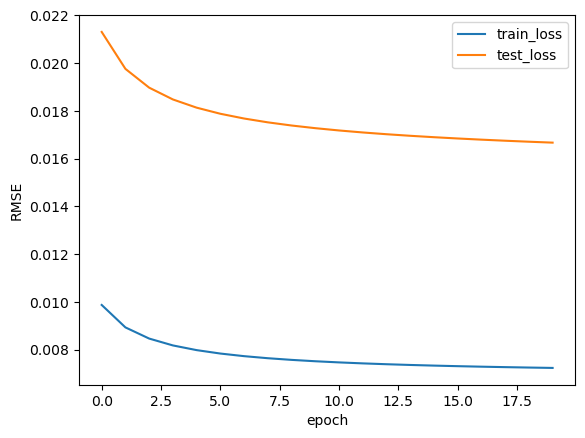

In [26]:
# Result
history = model.history

df = pd.DataFrame(history)
df.columns= ["epoch","train_loss","test_loss"]
print(df)
df.loc[:][["train_loss","test_loss"]].plot()
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

(671, 671)


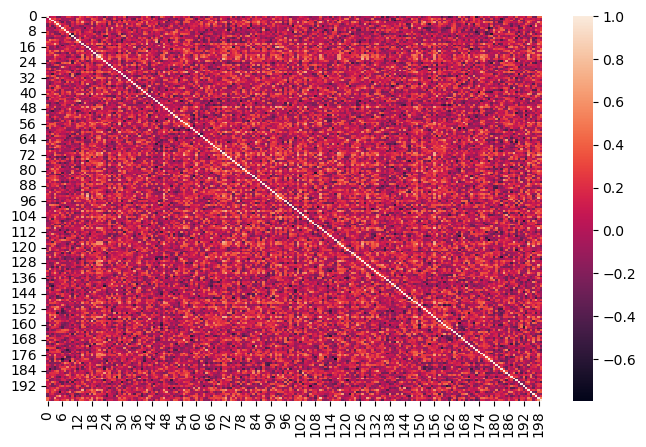

In [44]:
# Reco Process
corr = np.corrcoef(matrix)
print(corr.shape)

corr2 = corr[:200, :200]

plt.figure(figsize=(8,5))
sns.heatmap(corr2)

plt.show()

In [95]:
target_user_id = 3
target_user_idx = target_user_id - 1

sorted_idx = corr[target_user_idx].argsort()[::-1]

best_user_id = sorted_idx[1] + 1
worst_user_id = sorted_idx[-1] + 1

In [96]:
movies_df = pd.read_csv("datas/movielens_small/movies.csv")
movies_df.set_index("movieId", inplace=True)

movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [97]:
target_movie_ids = datas[datas['userId'] == target_user_id].sort_values("rating", ascending=False)['movieId'].values
best_movie_ids = datas[datas['userId'] == best_user_id].sort_values("rating", ascending=False)['movieId'].values
worst_movie_ids = datas[datas['userId'] == worst_user_id].sort_values("rating", ascending=False)['movieId'].values

target_movies = movies_df.loc[target_movie_ids]['title'].values
best_movies = movies_df.loc[best_movie_ids]['title'].values
worst_movies = movies_df.loc[worst_movie_ids]['title'].values

In [98]:
target_movies

array(['Fight Club (1999)', 'Shawshank Redemption, The (1994)',
       'Forrest Gump (1994)', 'Requiem for a Dream (2000)',
       'Princess Bride, The (1987)', 'Pulp Fiction (1994)',
       'Flags of Our Fathers (2006)', 'Letters from Iwo Jima (2006)',
       'Titanic (1997)', 'Frequency (2000)', 'Harold and Maude (1971)',
       'American Beauty (1999)', 'Stir of Echoes (1999)',
       'Happiness (1998)', 'Braveheart (1995)',
       'Fear and Loathing in Las Vegas (1998)', 'Young Guns (1988)',
       'Saving Private Ryan (1998)',
       'White Stripes Under Great White Northern Lights, The (2009)',
       'Trainspotting (1996)', 'V for Vendetta (2006)',
       'Daria: Is It Fall Yet? (2000)', 'Fahrenheit 9/11 (2004)',
       'Sixth Sense, The (1999)', 'Summer of Sam (1999)',
       'Bowling for Columbine (2002)', 'Heavenly Creatures (1994)',
       'Twister (1996)', 'Men in Black (a.k.a. MIB) (1997)',
       'Major Payne (1995)', 'Spider-Man (2002)', 'Spider-Man 2 (2004)',
       'Da

In [99]:
np.isin(best_movies,target_movies)

array([False, False,  True, False, False, False, False, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False])

In [100]:
np.isin(target_movies,best_movies)

array([ True,  True, False, False, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False])

In [101]:
np.isin(target_movies,worst_movies)

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [102]:
np.isin(worst_movies,target_movies)

array([ True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False])